# Two-Layer Fully Connected Network

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

# For CIFAR10
K = len(np.unique(y_train)) # Number of Classes; 10
Ntr = x_train.shape[0]  # Number of training samples; 50,000 
Nte = x_test.shape[0]   # Number of test samples; 10,000
Din = 3072 # CIFAR10

# Normalize pixel values
#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)   # Mean of the Image pixels 
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert 1-dimentional array class arrays to 10-dimentional class matrices 
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#Reshape and format
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)


In [3]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6
loss_history = []
train_acc_history = []
val_acc_history = []

In [4]:
#Define a function to calculate the loss
def calc_loss(y, y_pred, w1, w2 = 0):
    batch_size=y_pred.shape[0]
    loss = 1./batch_size*np.square(y_pred - y).sum() + reg*(np.sum(w2*w2) + np.sum(w1*w1))
    return loss

In [5]:
#Define function to calculate the accuracy
def accuracy(y_pred,y):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    acc=1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum() #Take max value in y and y_pred and take absolte value of the differece 
    return acc

In [10]:
H = 200

def twoLayerModel(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    std=1e-5
    #Middle hidden layer
    w1 = std*np.random.randn(Din, H)
    b1 = np.zeros(H)

    #Last layer
    w2 = std*np.random.randn(H, K)
    b2 = np.zeros(K)

    for t in range(iterations):
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]
        
        #forward propagation
        #Predict hypothesis
        h = 1.0/(1.0 + np.exp(-(x.dot(w1) + b1)))
        h_test= 1.0/(1.0 + np.exp(-(x_test.dot(w1) + b1)))

        #Predict values
        y_pred = h.dot(w2) + b2
        y_pred_test = h_test.dot(w2) + b2

        #calculate Losses 
        train_loss=calc_loss(y_pred,y,w1,w2)
        test_loss=calc_loss(y_pred_test,y_test,w1,w2)
        loss_history.append(train_loss)

        #Calculate accuracies 
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)
        
        if t%10 == 0:
            print('Epoch %3d/%d:==> Train Loss= %f | Test Loss= %f | Train Accuracy= %f | Test Accuracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        #backward propagation
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw2 = h.T.dot(dy_pred) + reg*w2
        db2 = dy_pred.sum(axis=0)
        dh = dy_pred.dot(w2.T)
        dw1 = x.T.dot(dh*h*(1-h))+reg*w1
        db1 = (dh*h*(1-h)).sum(axis=0) 
        w1-=lr*dw1
        w2-=lr*dw2
        b1-=lr*db1
        b2-=lr*db2
        lr*=lr_decay
        
    return w1,b1,loss_history,train_acc_history,val_acc_history

In [13]:
w1_2,b1_2,loss_history_2,train_acc_history_2,val_acc_history_2=twoLayerModel(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg)

Epoch   0/300:==> Train Loss= 1.000006 | Test Loss= 1.000006 | Train Accuracy= 0.690000 | Test Accuracy= 0.690000
Epoch  10/300:==> Train Loss= 0.868981 | Test Loss= 0.868767 | Train Accuracy= 0.704966 | Test Accuracy= 0.705340
Epoch  20/300:==> Train Loss= 0.846469 | Test Loss= 0.846543 | Train Accuracy= 0.716148 | Test Accuracy= 0.715360
Epoch  30/300:==> Train Loss= 0.833251 | Test Loss= 0.833444 | Train Accuracy= 0.732116 | Test Accuracy= 0.732760
Epoch  40/300:==> Train Loss= 0.822575 | Test Loss= 0.823148 | Train Accuracy= 0.742652 | Test Accuracy= 0.745590
Epoch  50/300:==> Train Loss= 0.809668 | Test Loss= 0.810431 | Train Accuracy= 0.754642 | Test Accuracy= 0.756950
Epoch  60/300:==> Train Loss= 0.802537 | Test Loss= 0.803957 | Train Accuracy= 0.760890 | Test Accuracy= 0.760110
Epoch  70/300:==> Train Loss= 0.804614 | Test Loss= 0.806303 | Train Accuracy= 0.764972 | Test Accuracy= 0.762350
Epoch  80/300:==> Train Loss= 0.788855 | Test Loss= 0.790954 | Train Accuracy= 0.770770 

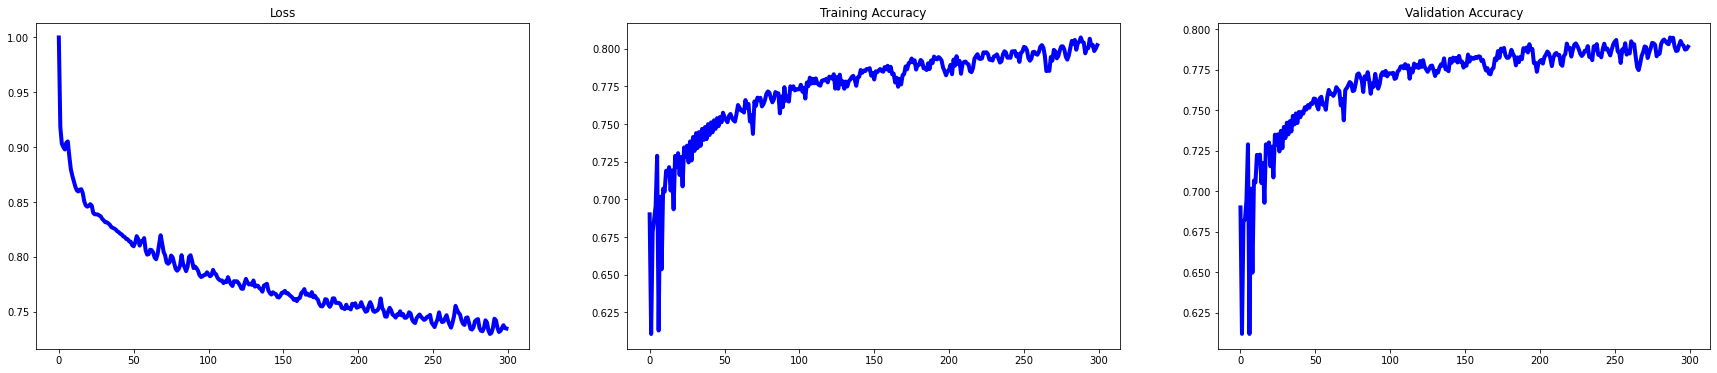

In [14]:
fig, axes  = plt.subplots(1,4, sharex='all', sharey='all', figsize=(30,6))
items = {"Loss":loss_history_2, "Training Accuracy":train_acc_history_2,"Validation Accuracy": val_acc_history_2}

graph = 1
for key in items.keys():
    plt.subplot(1,3,graph);plt.plot(items[key], color='#0000ff', linewidth=4)
    plt.title(key)
    graph+=1

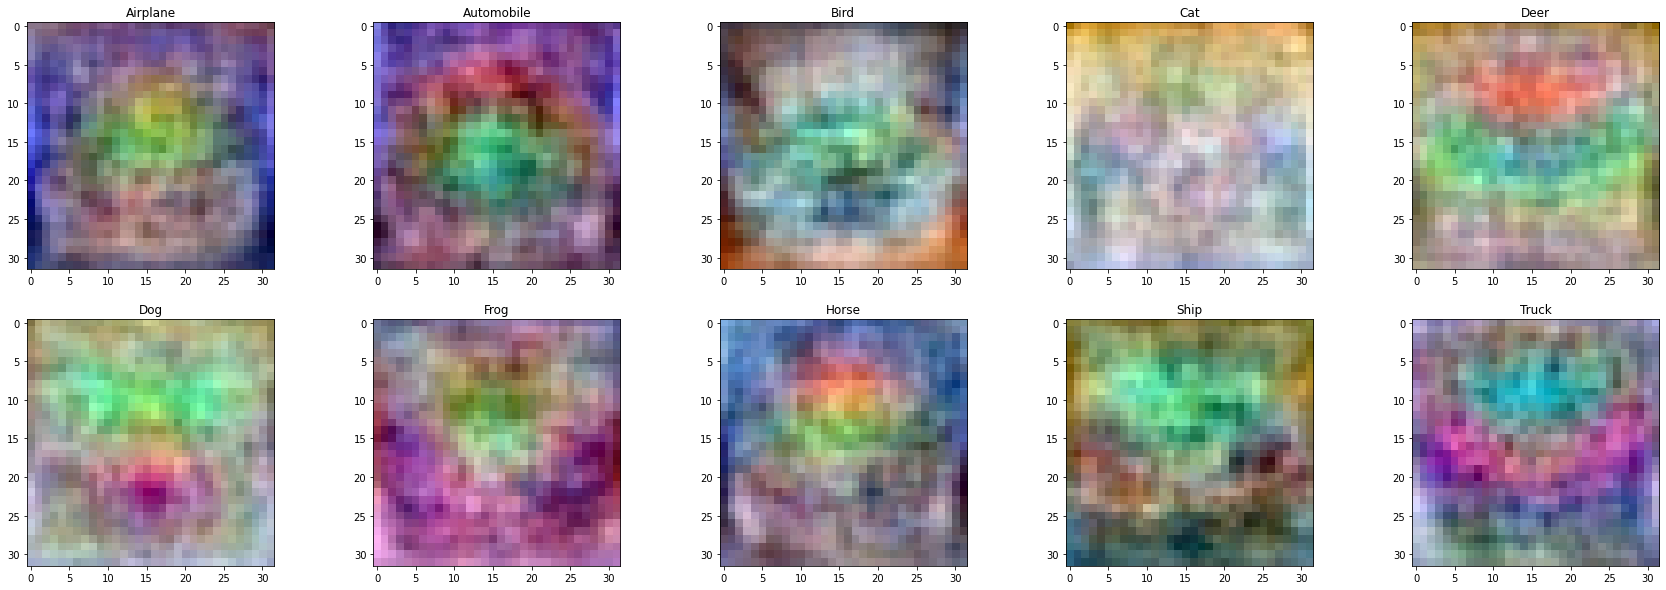

In [15]:
import cv2 as cv
images=[]
for i in range(w1_2.shape[1]):
    #images.append(np.reshape(w1[:,i]*255,(32,32,3))+np.reshape(mean_image,(32,32,3)))
    temp=np.reshape(w1_2[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
lst = [['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer'],['Dog','Frog','Horse','Ship','Truck']]
fig,ax=plt.subplots(2,5,figsize=(30,10))
for i in range(2):
    for j in range(5):
        ax[i,j].set_title(lst[i][j])
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
plt.show()